 <div style="text-align:center;">
   <span style="color:green; font-size:larger; font-weight:bold;">Exploratory Data Analysis (EDA)</span><br><br>
</div>


<span style="color:green; font-size:larger; font-weight:bold;">INTRODUCTION</span>

Dans cette partie, nous nous intéressons à l'analyse descriptive de la base de données "final_data" obtenue suite au nettoyage des bases de données initiales du fichier "Préparation_données.ipynb"

In [1]:
from importlib import reload
import declarations as d
reload(d)

c:\Users\user\Documents\FRANCE\python\Projet-Python\monmodule\declarations.py:23: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\Users\user\Documents\FRANCE\python\Projet-Python\monmodule\declarations.py:24: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
c:\Users\user\Documents\FRANCE\python\Projet-Python\monmodule\declarations.py:26: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table


<module 'declarations' from 'c:\\Users\\user\\Documents\\FRANCE\\python\\Projet-Python\\monmodule\\declarations.py'>

In [27]:
#Importer de la base de données
df = d.pd.read_csv("./bases/final_data.csv")
df.head()

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694
2,1994-01,CAN,10.700000,0.680429,77.871707,1.095258
3,1994-01,AUT,6.609708,0.779464,76.419512,0.384870
4,1994-01,PHL,9.450000,0.329061,67.942000,2.343515


In [20]:
# Telecharger le shapefile
world = d.gpd.read_file(d.gpd.datasets.get_path('naturalearth_lowres'))
world=world.rename(columns={'iso_a3': 'COUNTRY'})
# Transformation
world.to_crs('EPSG:4326') # Transformer les coordonnées géographiques en coordonnées projetées.
world.head()

C:\Users\user\AppData\Local\Temp\ipykernel_3192\4162701455.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,COUNTRY,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [28]:
#selectioner certaines colonnes 
world.drop(world.columns.difference(['geometry','COUNTRY','continent']), 1, inplace=True)
# fusionner les deux photos
world_df = d.pd.merge(world,df, how='inner', on=['COUNTRY'])
world_df.head(5)
#world.head()

C:\Users\user\AppData\Local\Temp\ipykernel_3192\2209799755.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



,continent,COUNTRY,geometry,YEAR,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-01,10.700000,0.680429,77.871707,1.095258
1,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-04,10.866667,0.689810,77.871707,1.095258
2,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-07,10.366667,NaN,NaN,NaN
3,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-10,10.150000,NaN,NaN,NaN
4,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1995-01,9.550000,0.694571,77.977317,1.034769


In [ ]:
world_df.head()

,continent,COUNTRY,geometry,YEAR,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-01,10.700000,0.680429,77.871707,1.095258
1,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-02,10.866667,0.680180,77.871707,1.095258
2,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-03,10.366667,0.686270,77.871707,1.095258
3,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1994-04,10.150000,0.689810,77.871707,1.095258
4,North America,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1995-01,9.550000,0.694571,77.977317,1.034769


# <span style="color:green; text-align:center;">I- TRAITEMENT DES DONNEES</span>

# <span style="color:green; text-align:center;">II- VISUALISATION DES DONNEES</span>

<Axes: >

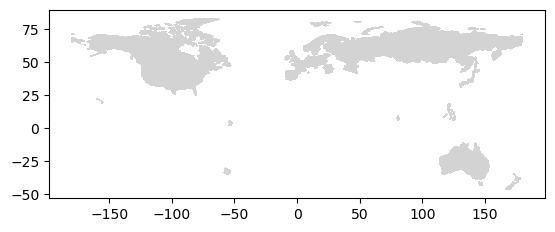

In [8]:
world_df.plot(color='lightgrey')

Deux applications seront créer pour la visualition des données:
- la premiere sera instantanné et à l'echelle mondiale
-la seconde c'est la representation de la serie temporelle par continent.

In [15]:
# Creer un Dash app
app1 = d.dash.Dash(__name__)

# Créer une carte centrée sur la position moyenne des pays
# Obtenez les limites totales des géométries reprojeter
bounds = world_df.geometry.total_bounds

# Calculer le centre
map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]


# Definir le layout 
app1.layout = d.html.Div([
    #selecteur d'année
    d.dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in sorted(world_df['YEAR'].unique())],
        value=world_df['YEAR'].min(),  #valeur par defaut de l'année
        multi=False,
    ),
    #selecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    d.dcc.Graph(id='choropleth-map'),
])

# Definir un callback  pour mettre à jour la carte sur l'année selectionnée 
@app1.callback(
    d.Output('choropleth-map', 'figure'),
    [d.Input('year-dropdown', 'value'),
     d.Input('variable-dropdown', 'value')]
)
def update_map(selected_year, selected_variable):
    subset_gdf = world_df[world_df['YEAR'] == selected_year]
    subset_gdf.index = subset_gdf['COUNTRY']
    fig = d.px.choropleth(
        subset_gdf,
        geojson=subset_gdf.geometry,
        locations=subset_gdf.index,
        color=selected_variable,
        projection="natural earth",
        title=f'{selected_variable} in {selected_year}',
    )
    fig.update_geos(fitbounds="locations", visible=True)
    # Ajouter une couche choroplèthe à la carte


    fig.update_layout ( margin = { "r" : 0 , "t" : 0 , "l" : 0 , "b" : 0 }) 
    return fig

# executer l'application
if __name__ == '__main__':
    app1.run_server(debug=True, port=8050)


In [30]:

df=world_df.copy()
df.index=df['YEAR']
# Supprimer les valeurs manquantes et trier par index
df = df.dropna().sort_index()
app2 = d.dash.Dash(__name__)

# Créez votre graphique initial
fig = d.px.line(df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')

# Créez la mise en page de votre application Dash
app2.layout = d.html.Div([
    # Sélecteur de continents
    d.dcc.Dropdown(
        id='continent-selector',
        options=[
            {'label': continent, 'value': continent}
            for continent in df['continent'].unique()
        ],
        multi=True,
        value=df['continent'].unique()  # Sélectionnez tous les continents par défaut
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='line-chart',
        figure=fig
    )
])

# Définissez la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app2.callback(
    d.Output('line-chart', 'figure'),
    [d.Input('variable-dropdown', 'value'),
     d.Input('continent-selector', 'value')]
)
def update_graph2(selected_variable,selected_continents):
    filtered_df = df[df['continent'].isin(selected_continents)]
    #fig = px.line(filtered_df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')
    fig = d.px.line(filtered_df, x='YEAR', y=[selected_variable], color='COUNTRY',
                   labels={'YEAR': 'Année', selected_variable: selected_variable})
    return fig


# Exécutez l'application Dash
if __name__ == '__main__':
    app2.run_server(debug=True, port=8051)


In [35]:
df_group=df.groupby('COUNTRY')['Unemployment_rate', 'GDP_rate',
                      'life_expentancy','pop_growth_rate'].mean().reset_index()

df_group.head()

C:\Users\user\AppData\Local\Temp\ipykernel_3192\590753506.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,AUS,6.124572,0.751199,80.937227,1.341199
1,AUT,7.265766,0.891314,79.733847,0.454410
2,BEL,7.851217,0.905294,79.505058,0.502098
3,BGR,10.808289,0.775441,72.866230,-0.840173
4,CAN,7.552924,0.912815,80.489381,1.039578


In [39]:
app3 = d.dash.Dash(__name__)

# Créez votre graphique initial
fig = d.px.bar(df_group, x='COUNTRY', y='Unemployment_rate', color='COUNTRY',
             labels={'COUNTRY': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             #title='Taux de chômage moyen par pays sur la période 2019-2023',
             template='plotly_dark')

# Créez la mise en page de votre application Dash
app3.layout = d.html.Div([
    
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='bar',
        figure=fig
    )
])

# Définissez la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app3.callback(
    d.Output('bar', 'figure'),
    [d.Input('variable-dropdown', 'value')]
)
def update_graph3(selected_variable):
    #fig = px.line(filtered_df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')
    fig = d.px.bar(df, x='COUNTRY', y=[selected_variable], color='COUNTRY',
                   labels={'COUNTRY': 'Pays', selected_variable: selected_variable},
                   template='plotly_dark')
    return fig


# Exécutez l'application Dash
if __name__ == '__main__':
    app3.run_server(debug=True, port=8052)


In [36]:
# Créez un graphique interactif avec Plotly Express
fig = d.px.bar(df_group, x='COUNTRY', y='Unemployment_rate', color='COUNTRY',
             labels={'COUNTRY': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             title='Taux de chômage moyen par pays sur la période 2019-2023',
             template='plotly_dark')

# Affichez le graphique interactif
fig.show()